In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import processing
from utils import utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (18,10)

In [3]:
kld = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])
stb = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])

In [4]:
# Processing Parameters
split = 0.80 # split percentage for training data
steps = 1 # timesteps: 1 hour

lookback = 24 * 7 # the number of hours in the past the model is shown
horizon = 1 # the target hour in the future we want to predict 1 hour ahead

# Training parameters
batch_size = 256
epochs = 50
lr = 0.001

In [5]:
# Create Train, Val, and Test Sets
kld_train, kld_val, kld_test = processing.create_datasets(kld, split=split, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')
stb_train, stb_val, stb_test = processing.create_datasets(stb, split=split, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')

In [6]:
for batch in kld_train.take(1):
    inputs, targets = batch
    
print(f"Input Shape: {inputs.numpy().shape}")
print(f"Target Shape: {targets.numpy().shape}")

Input Shape: (256, 168, 7)
Target Shape: (256, 1)


In [13]:
CNN_base = Sequential()
CNN_base.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(inputs.shape[1], inputs.shape[2])))
CNN_base.add(MaxPooling1D(pool_size=2))
CNN_base.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
CNN_base.add(MaxPooling1D(pool_size=2))
CNN_base.add(Flatten())
CNN_base.add(Dropout(0.25))
CNN_base.add(Dense(64, activation='relu'))
CNN_base.add(Dense(1))

CNN_base.compile(optimizer=Adam(learning_rate=lr), loss='mse')
             
CNN_base.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 167, 64)           960       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 83, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 82, 128)           16512     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 41, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5248)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5248)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [15]:
# Callbacks
ckpt_path = "../model/models/CNN_base.h5"
estp = EarlyStopping(monitor='val_loss', patience=10)

ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

In [16]:
history = CNN_base.fit(
    kld_train,
    epochs=epochs,
    validation_data=kld_val,
    callbacks=[estp, ckpt]
)

Epoch 1/50
60/60 [==============================] - 5s 81ms/step - loss: 1.2221 - val_loss: 1.2117

Epoch 00001: val_loss improved from inf to 1.21166, saving model to ../model/models\CNN_base.h5
Epoch 2/50
60/60 [==============================] - 4s 74ms/step - loss: 0.7039 - val_loss: 0.3581

Epoch 00002: val_loss improved from 1.21166 to 0.35814, saving model to ../model/models\CNN_base.h5
Epoch 3/50
60/60 [==============================] - 4s 73ms/step - loss: 0.2799 - val_loss: 0.2382

Epoch 00003: val_loss improved from 0.35814 to 0.23818, saving model to ../model/models\CNN_base.h5
Epoch 4/50
60/60 [==============================] - 4s 74ms/step - loss: 0.1999 - val_loss: 0.2664

Epoch 00004: val_loss did not improve from 0.23818
Epoch 5/50
60/60 [==============================] - 4s 73ms/step - loss: 0.1958 - val_loss: 0.2001

Epoch 00005: val_loss improved from 0.23818 to 0.20005, saving model to ../model/models\CNN_base.h5
Epoch 6/50
60/60 [==============================] - 4

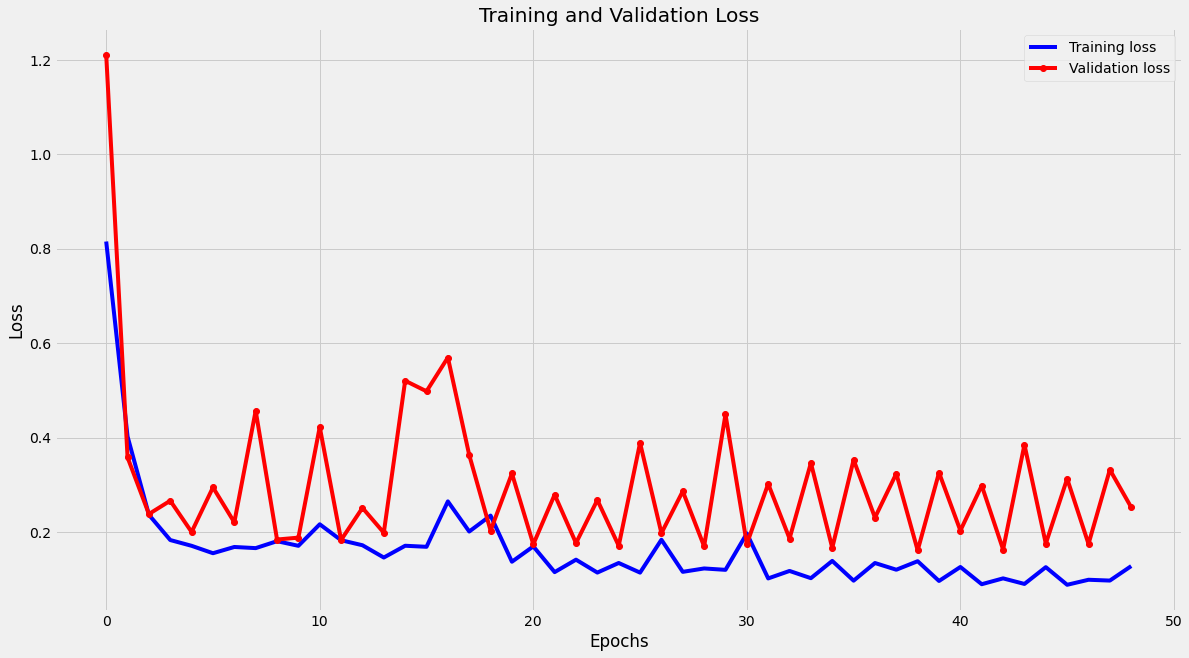

In [17]:
utils.plot_training(history, "Training and Validation Loss")

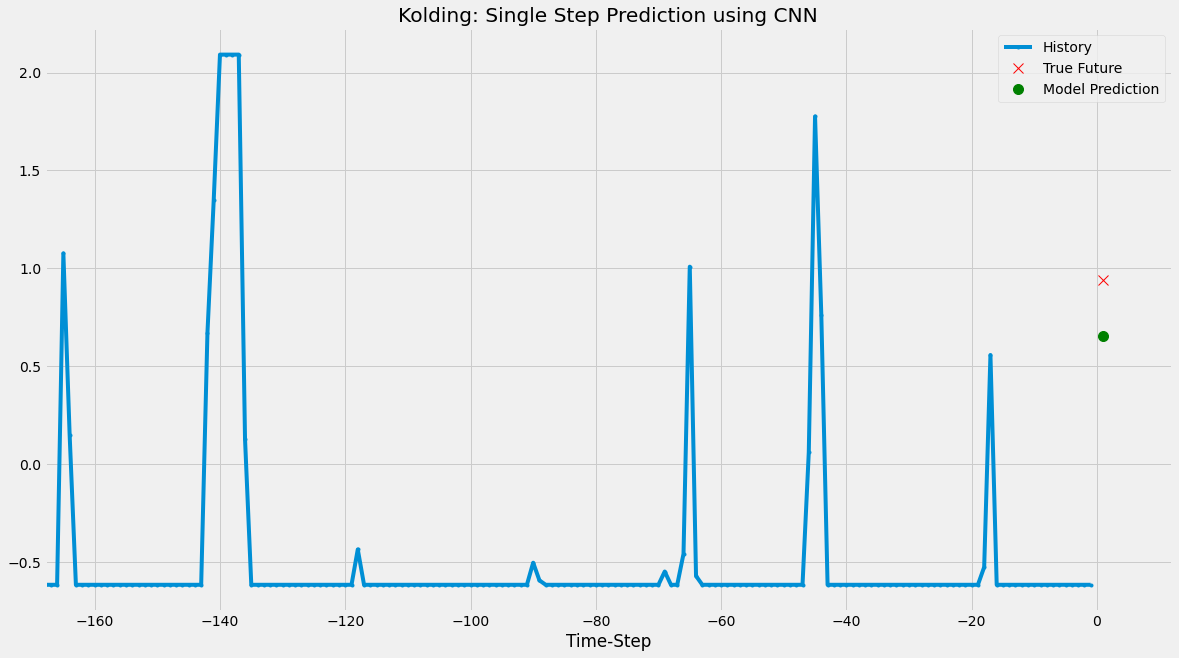

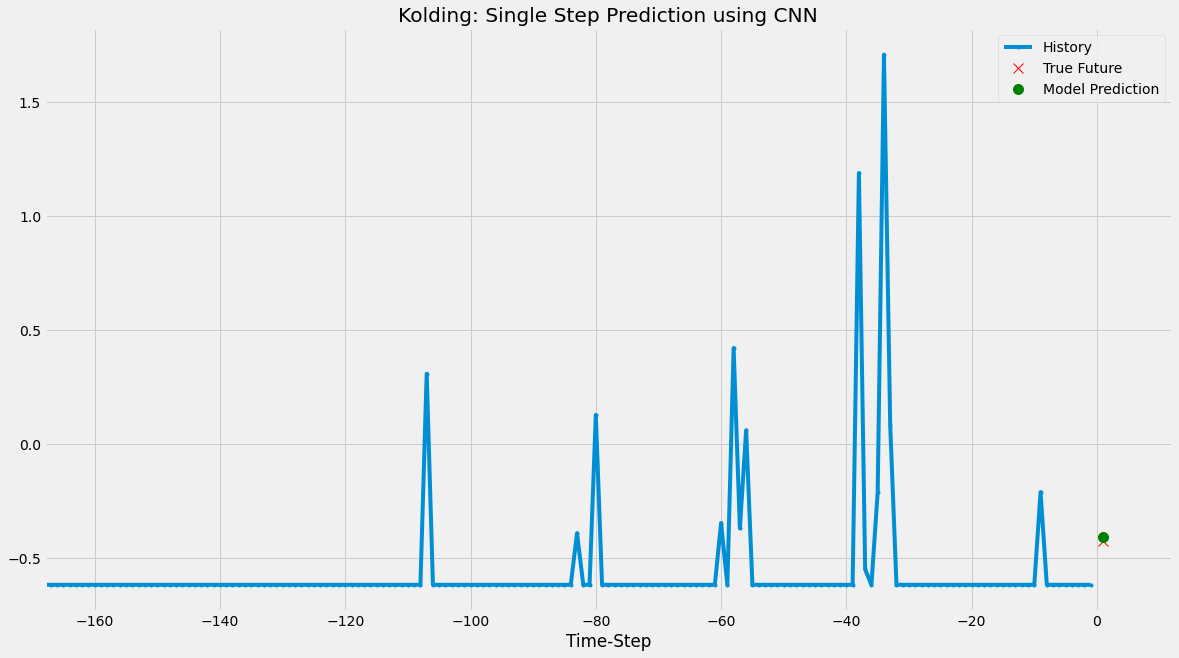

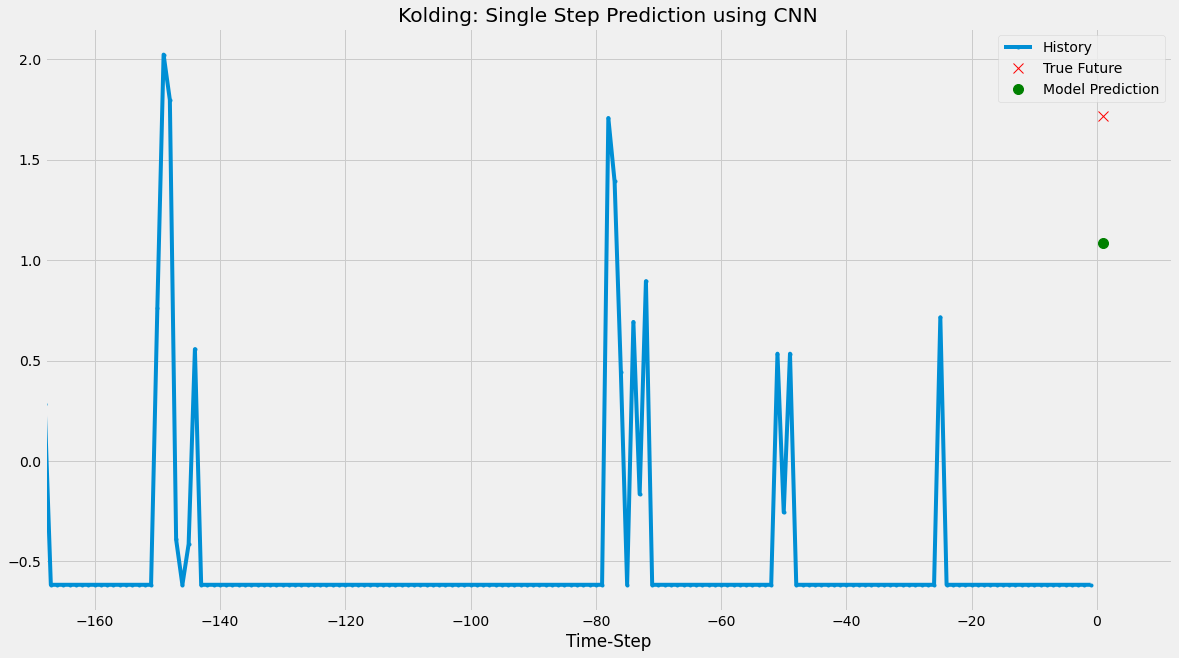

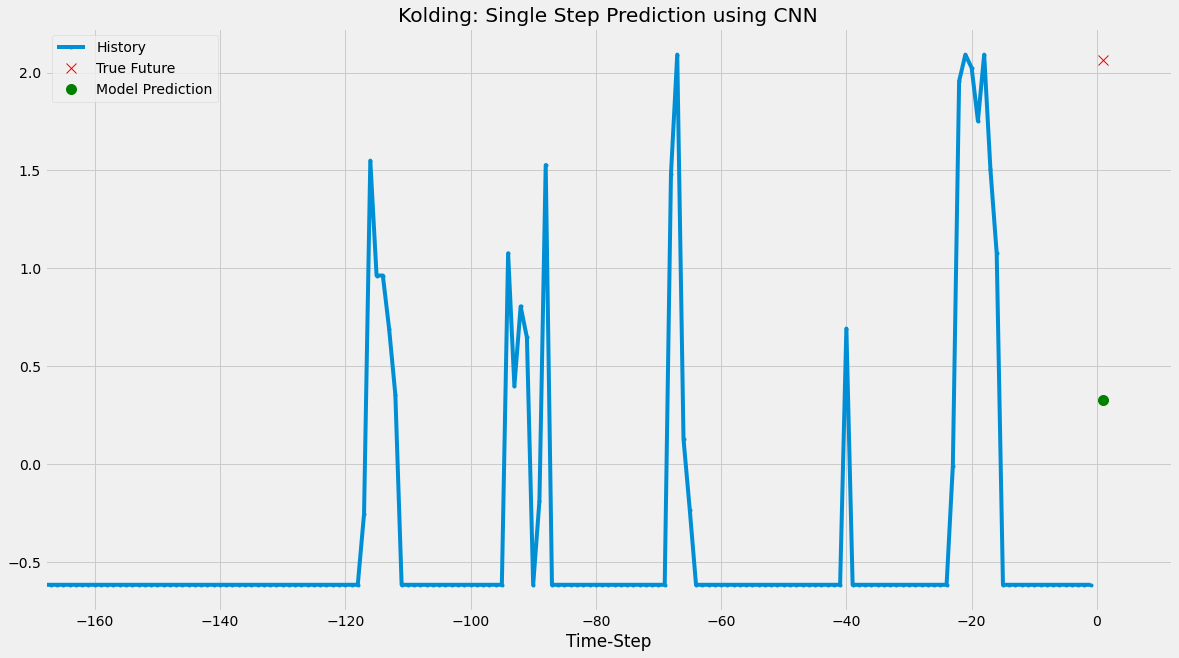

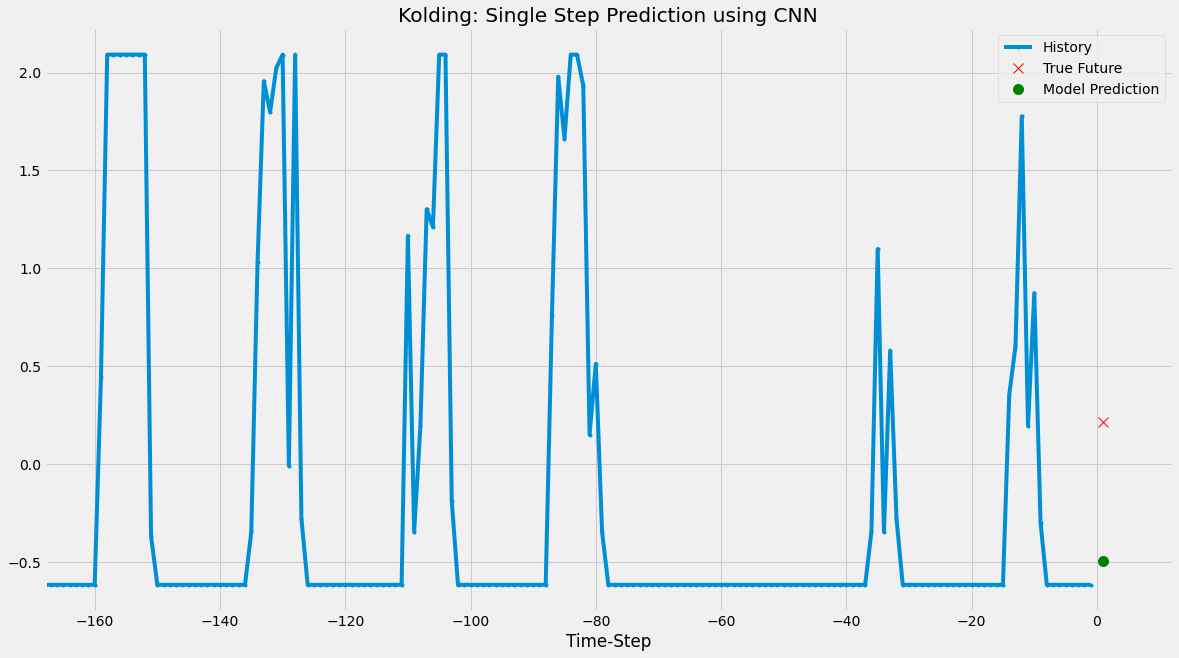

In [18]:
# Predictions
for x, y in kld_test.take(5):
    utils.plot_pred(
        [x[0][:, 1].numpy(), y[0].numpy(), CNN_base.predict(x)[0]],
        1,
        "Kolding: Single Step Prediction using CNN",
    )
